<a href="https://colab.research.google.com/github/igorlauxen/local_grape_health/blob/main/Predicao_uvas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 2 - Convolutional Neural Networks (CNNs)

Baseado em [Cat vs Dog Classification](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=dhztKtUSFMX)

Carregando os arquivos do drive

In [ ]:
# caso precise pegar os arquivo via drive, essa é opção
from google.colab import drive

# This will prompt for authorization.
# drive.mount('/content/drive')
# cd to where we have files
# mostra o que tem na pasta
#!ls /content/drive/MyDrive/unisinos/'pos graduacao'/'seminario 2 - classificação de plantas saudaveis'/dados/train/Grape_healthy/

# entra na pasta
%cd /content/drive/MyDrive/unisinos/'pos graduacao'/'seminario 2 - classificação de plantas saudaveis'/dados/train/Grape_healthy/
# mostra os primeiros conteudos da pasta
!ls -U | head -4


/content/drive/MyDrive/unisinos/pos graduacao/seminario 2 - classificação de plantas saudaveis/dados/train/Grape_healthy
698a1cd5-2ad0-4a76-bb73-65918083df56___Mt.N.V_HL 6160_180deg.JPG
508d0cc9-05ef-488a-aa84-1f28073954d4___Mt.N.V_HL 6163.JPG
9d1124c3-4be4-4998-b1f8-92b0d0f699a1___Mt.N.V_HL 8917_180deg.JPG
0f0596ab-ea6e-472b-a7d5-0a80b1d1ebb2___Mt.N.V_HL 9011_90deg.JPG


Neste notebook iremos utilizar a biblioteca [Keras](https://www.keras.io) para construir redes neurais do tipo Convolutional Neural Networks (CNNs).

Neste exemplo, iremos criar uma CNN para classificar imagens do dataset CIFAR-10. As imagens deste dataset são classificadas em 10 categorias.

Para começar, precisamos importar algumas bibliotecas.

In [1]:
import keras
#from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Para utilizar o dataset em questão, basta executar o comando abaixo.  Este comando retorna duas tuplas, as quais representam os dados de treino (entrada e saída) e de teste (entrada e saída). 
Será usado os dados importados do Google drive ao inves do cifar

In [2]:
# carregando os arquivo dos drive e colocando em uma folder tmp
# original url https://drive.google.com/file/d/1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA/view?usp=sharing

# baseado em
# https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99

# caso o arquivo seja menor que 100 mega
#!wget --no-check-certificate \
#   https://docs.google.com/uc?export=download&id=1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA -O \
#   /tmp/cats_and_dogs_filtered.zip

# como o arquivo tem mais de 100
!wget --load-cookies  \
  /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA" -O \
   /tmp/dados.zip && rm -rf /tmp/cookies.txt

--2021-11-30 00:34:01--  https://docs.google.com/uc?export=download&confirm=bFNH&id=1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA
Resolving docs.google.com (docs.google.com)... 74.125.140.102, 74.125.140.138, 74.125.140.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.140.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-1k-docs.googleusercontent.com/docs/securesc/06vk6r3g80vc37fn8l35fuf4p1us54qs/604ri45j1fsvqjf08u4obgs9bjk07h4e/1638232425000/05432163893309325293/08994821594691544242Z/1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA?e=download [following]
--2021-11-30 00:34:01--  https://doc-0g-1k-docs.googleusercontent.com/docs/securesc/06vk6r3g80vc37fn8l35fuf4p1us54qs/604ri45j1fsvqjf08u4obgs9bjk07h4e/1638232425000/05432163893309325293/08994821594691544242Z/1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA?e=download
Resolving doc-0g-1k-docs.googleusercontent.com (doc-0g-1k-docs.googleusercontent.com)... 108.177.15.132, 2a00:1450:400c:c0c::84
Connecting

In [3]:
!ls /tmp/

dados.zip
dap_multiplexer.808044384a85.root.log.INFO.20211130-003016.61
dap_multiplexer.INFO
debugger_ccfwagd1a
initgoogle_syslog_dir.0


Com o arquivo baixado, agora vamos extrair ele e criar os respectivos repositorios

In [4]:
import os
import zipfile

local_zip = '/tmp/dados.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/dados_extraidos/')
zip_ref.close()
  
base_dir = '/tmp/dados_extraidos/dados'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_healthy_dir = os.path.join(train_dir, 'Grape___healthy')

# Directory with our training dog pictures
train_sick_dir = os.path.join(train_dir, 'Grape___Black_rot')

# Directory with our validation cat pictures
validation_healthy_dir = os.path.join(validation_dir, 'Grape___healthy')

# Directory with our validation dog pictures
validation_sick_dir = os.path.join(validation_dir, 'Grape___Black_rot')

train_healthy_fnames = os.listdir(train_healthy_dir)
train_sick_fnames = os.listdir(train_sick_dir)

Next, let's apply the datagen transformations to a cat image from the training set to produce five random variants. Rerun the cell a few times to see fresh batches of random variants.

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


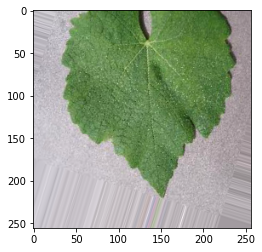

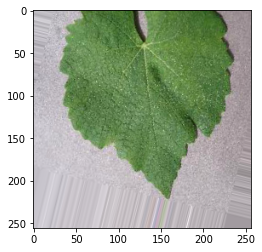

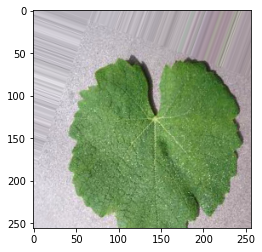

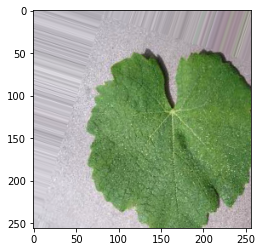

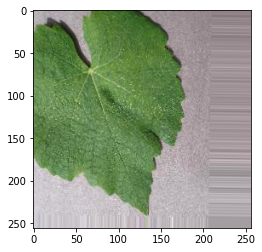

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

image_size = 256 # WARNING THIS WILL DICTATE THE SIZE OF THE UPCOMING IMAGES PROCESSING

img_path = os.path.join(train_healthy_dir, train_healthy_fnames[2])
img = load_img(img_path, target_size=(image_size, image_size))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (32, 32, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 32, 32, 3)

datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

## Add Data Augmentation to the Preprocessing Step

Now let's add our data-augmentation transformations from [**Exploring Data Augmentation**](#scrollTo=E3sSwzshfSpE) to our data preprocessing configuration:

In [6]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(image_size, image_size),  # All images will be resized to 32x32
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=20,
        class_mode='binary')

Found 7222 images belonging to 4 classes.
Found 1805 images belonging to 4 classes.


If we train a new network using this data augmentation configuration, our network will never see the same input twice. However the inputs that it sees are still heavily intercorrelated, so this might not be quite enough to completely get rid of overfitting

## Adding Dropout

Another popular strategy for fighting overfitting is to use **dropout**.

**TIP:** To learn more about dropout, see [Training Neural Networks](https://developers.google.com/machine-learning/crash-course/training-neural-networks/video-lecture) in [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

Let's reconfigure our convnet architecture from Exercise 1 to add some dropout, right before the final classification layer:

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# in case we need custom losses: https://keras.io/guides/training_with_built_in_methods/
# in Custom losses section

# Our input feature map is image_sizeximage_sizex3: image_sizeximage_size for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(image_size, image_size, 3))

# First convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.3)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Execução do modelo

In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
100/100 - 39s - loss: -3.7377e+07 - acc: 0.2550 - val_loss: -1.8297e+08 - val_acc: 0.2700 - 39s/epoch - 386ms/step
Epoch 2/30
100/100 - 37s - loss: -1.1726e+09 - acc: 0.2670 - val_loss: -2.9609e+09 - val_acc: 0.2600 - 37s/epoch - 373ms/step
Epoch 3/30
100/100 - 37s - loss: -7.0679e+09 - acc: 0.2570 - val_loss: -1.5262e+10 - val_acc: 0.2570 - 37s/epoch - 373ms/step
Epoch 4/30
100/100 - 37s - loss: -2.8888e+10 - acc: 0.2635 - val_loss: -4.4333e+10 - val_acc: 0.2690 - 37s/epoch - 370ms/step
Epoch 5/30
100/100 - 37s - loss: -7.8599e+10 - acc: 0.2570 - val_loss: -1.1903e+11 - val_acc: 0.2690 - 37s/epoch - 371ms/step
Epoch 6/30
100/100 - 37s - loss: -1.9414e+11 - acc: 0.2720 - val_loss: -2.8656e+11 - val_acc: 0.2820 - 37s/epoch - 371ms/step
Epoch 7/30
100/100 - 37s - loss: -4.2558e+11 - acc: 0.2675 - val_loss: -5.9373e+11 - val_acc: 0.2530 - 37s/epoch - 375ms/step
Epoch 8/30
100/100 - 37s - loss: -7.2126e+11 - acc: 0.2695 - val_loss: -1.0464e+12 - val_acc: 0.2730 - 37s/epoch - 374

Resultados

Text(0.5, 1.0, 'Training and validation loss')

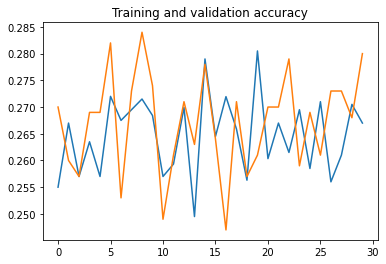

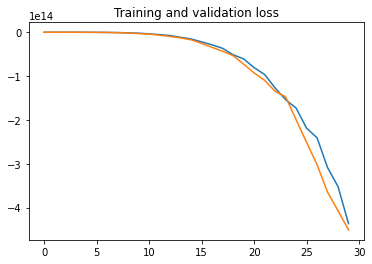

In [13]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

# score = model.evaluate(x_test, y_test, verbose=0)
# print('\n', 'Acurácia:', score[1])

Predição com as minhas uvas

In [ ]:
# Importar as minhas uvas
# "https://drive.google.com/file/d/1c9j1OBrcbF4rd1n6iXiiTZ9zo5IbdOYY/view?usp=sharing"

# caso o arquivo seja menor que 100 mega
!wget --no-check-certificate \
   https://docs.google.com/uc?export=download&id=1c9j1OBrcbF4rd1n6iXiiTZ9zo5IbdOYY -O \
   /tmp/minhasuvas.zip

local_zip = '/tmp/minhasuvas.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/minhas_uvas_extraidas/')
zip_ref.close()
  
base_dir = '/tmp/minhas_uvas_extraidas/'
minhas_uvas_saudaveis_dir = os.path.join(base_dir, 'Grape___healthy')

validate_healthy_fnames = os.listdir(minhas_uvas_saudaveis_dir)

img_path = os.path.join(minhas_uvas_saudaveis_dir, validate_healthy_fnames[2])
img = load_img(img_path, target_size=(image_size, image_size))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (32, 32, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 32, 32, 3)

datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

# Flow validation images in batches of 32 using val_datagen generator
minhas_uvas_generator = val_datagen.flow_from_directory(
        minhas_uvas_saudaveis_dir,
        target_size=(image_size, image_size),
        batch_size=20,
        class_mode='binary')


In [ ]:
model.predict(
    x,
    batch_size=None,
    verbose=0,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

Podemos visualizar alguns exemplos (entrada e saída) do dataset utilizando o código abaixo.

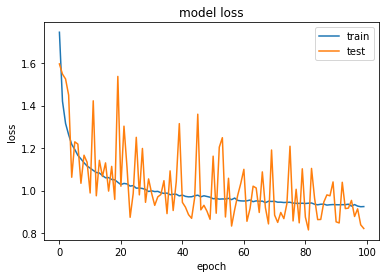

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Exemplo 2

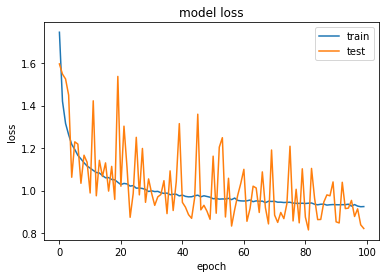

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

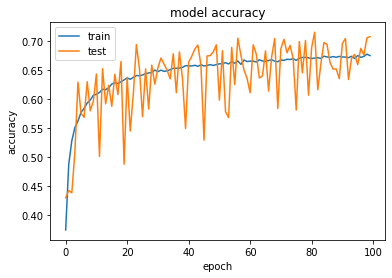

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Após concluir o treino, podemos carregar o melhor modelo utilizando o comando abaixo.

In [ ]:
# carrega os pesos do melhor modelo encontrado no treinamento
model.load_weights('model.weights.best.hdf5')

A acurácia pode ser medida como segue.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7017999887466431


Finalmente, podemos visualizar algumas predições do nosso modelo para entender melhor seu comportamento.

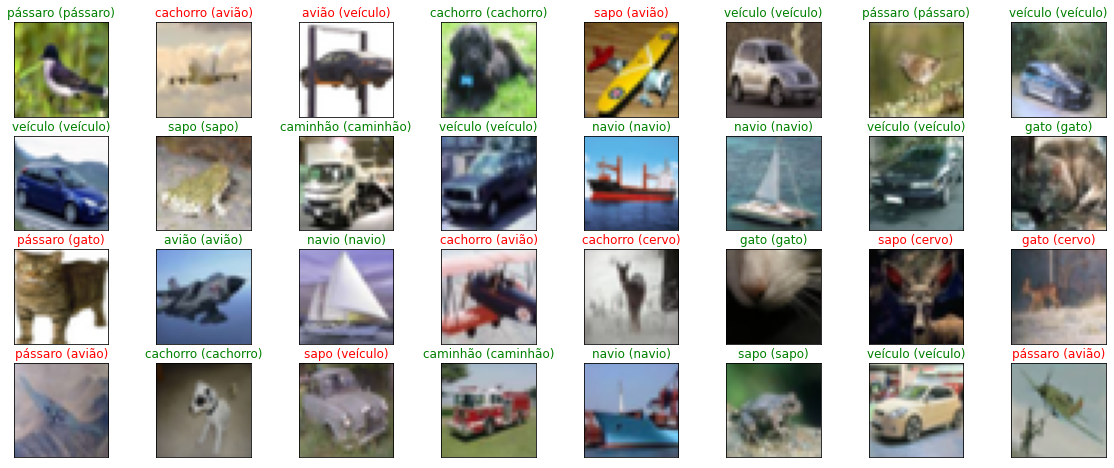

In [ ]:
# obtém as predições
y_hat = model.predict(x_test)

# define os labels (fonte: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['avião', 'veículo', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

# exibe alguns exemplos aleatórios do teste, bem como sua predição e o resultado esperado
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

## Exercícios

### Exercício 1

Ajuste a rede CNN vista acima para obter uma acurácia melhor no dataset CIFAR-10. Sua tarefa consiste em modificar a arquitetura da rede (e.g., quantidade de camadas, ordem das camadas, tamanho das camadas, loss function, otimizador, número de épocas, etc.).

In [ ]:
# your answer here